In [3]:

from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
import numpy as np
import matplotlib.pyplot as plt

# find the coordinates for M13 in Simbad

# add fields to Simbad query
Simbad.add_votable_fields("parallax", "propermotions", "coordinates", "sp", "velocity", "dimensions")

#m13 coordinates
m13_simbad = Simbad.query_object("m13")
#m13_pmracosdec = m13_simbad['pmra']*np.cos(m13_simbad['pmdec'])
m13_center = SkyCoord(ra=m13_simbad['ra'], dec=m13_simbad['dec'], pm_ra_cosdec=m13_simbad['pmra'],pm_dec=m13_simbad['pmdec'])[0]
m13_diam = m13_simbad["galdim_majaxis"][0]*u.arcmin
m13_parallax = m13_simbad["plx_value"][0]*u.mas

print(f"""M13
***
center {m13_center}
diameter {m13_diam}
parallax {m13_parallax} (distance {1000*(u.pc*u.mas)/m13_parallax})
""")

M13
***
center <SkyCoord (ICRS): (ra, dec) in deg
    (250.423475, 36.46131944)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (-3.18, -2.56)>
diameter 33.0 arcmin
parallax 0.127 mas (distance 7874.015748031496 pc)



In [ ]:
# query GAIA for stars in the target area

column_list = ['gaia.source_id',
               'gaia.ra',
               'gaia.dec',
               'gaia.pmra',
               'gaia.pmdec',
               'gaia.parallax',
               'gaia.phot_g_mean_mag',
               'gaia.phot_rp_mean_mag',
               'gaia.phot_bp_mean_mag',
               'best.number_of_neighbours',
               'best.number_of_mates',
               'ps.g_mean_psf_mag',
               'ps.r_mean_psf_mag',
               'ps.i_mean_psf_mag',
               'ps.z_mean_psf_mag',
               'ps.y_mean_psf_mag']

columns = ", ".join(column_list)

query_base = """SELECT
    {columns}
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.panstarrs1_original_valid as ps
        ON best.original_ext_source_id = ps.obj_id

        WHERE
            {circle}
"""


def adql_between(low,high):
    '''return a BETWEEN [low] AND [high] clause '''
    return f'BETWEEN {low} AND {high}'

def adql_contains_circle(center, radius):
    '''return a CONTAINS CIRCLE clause for ra, dec with given center and radius'''
    return f'1=CONTAINS( POINT(gaia.ra,gaia.dec), CIRCLE({center.ra.value}, {center.dec.value}, {radius.value}))'

parallax_center = m13_simbad['plx_value'].data[0]
parallax_range = adql_between(parallax_center/2, parallax_center*2)
circle = adql_contains_circle(m13_center, Angle("2 deg"))


query = query_base.format(columns=columns, parallax_range=parallax_range, circle=circle)
print(query)


SELECT
    gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, gaia.parallax, gaia.phot_g_mean_mag, gaia.phot_rp_mean_mag, gaia.phot_bp_mean_mag, best.number_of_neighbours, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiadr3.panstarrs1_best_neighbour as best
        ON gaia.source_id = best.source_id
    JOIN gaiadr2.panstarrs1_original_valid as ps
        ON best.original_ext_source_id = ps.obj_id

        WHERE
            1=CONTAINS( POINT(gaia.ra,gaia.dec), CIRCLE(250.4234749999999, 36.46131944444445, 2.0))



In [43]:
# launch the query

job = Gaia.launch_job_async(query)

INFO: Query finished. [astroquery.utils.tap.core]


In [57]:
results = job.get_results()
results

source_id,ra,dec,pmra,pmdec,parallax,phot_g_mean_mag,phot_rp_mean_mag,phot_bp_mean_mag,number_of_neighbours,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,mas,mag,mag,mag,,,,mag
int64,float64,float64,float64,float64,float64,float32,float32,float32,int16,int16,float64,float64
1328148886019165312,251.19657159777518,36.66521743371527,-1.9387789747932647,2.92339016305953,0.3261783215904644,19.802975,18.791725,20.692404,1,0,21.1313991546631,19.1641998291016
1328148890315820544,251.18832021314356,36.65899992259752,2.7473615074522053,-20.269761119916165,0.87494288364307,16.111042,15.515383,16.540815,1,0,16.6219997406006,15.8765001296997
1328148920378908416,251.19524095567036,36.67871713210052,-8.14962659718603,1.8222375567086273,0.9489412985976448,18.579163,17.605202,19.548937,1,0,19.9186992645264,17.9817008972168
1328148920378909824,251.21119699326678,36.6808416707213,-1.414807287995903,-2.637838867064211,0.36893606032593534,17.237986,16.714687,17.601494,1,0,17.6471996307373,17.0524997711182
1328148920378912256,251.20606911496108,36.686203378091115,-2.8204833170546344,-3.5052299003178042,-0.8149234316069024,20.214968,19.496704,20.296352,1,0,20.1905002593994,19.8759994506836
1328148954738647936,251.17711621518092,36.68118269562225,-5.962042866437162,-0.3141348054018718,-0.5738088744489167,20.759531,19.746695,21.275583,1,0,21.8332004547119,20.1686000823975
1328148954738649728,251.18572832635422,36.682977034070746,-5.566544898450853,-8.894269635439807,0.2844340484068064,19.349821,18.534363,20.161661,1,0,20.4687004089355,18.827299118042
1328148954738652416,251.17924106108669,36.68853067204275,-1.7289451054173912,-6.639191817480214,0.7177708688760454,20.290676,19.33908,21.071255,1,0,21.7567005157471,19.6263999938965


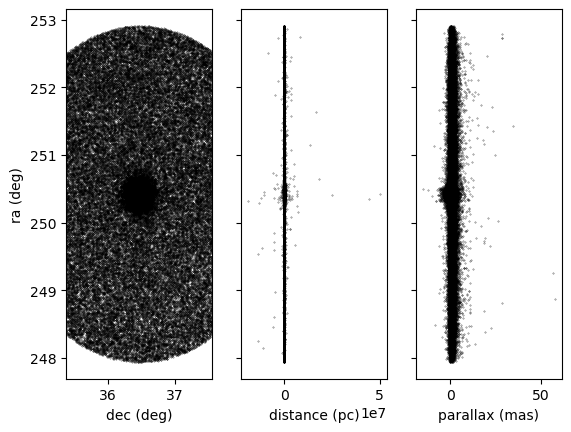

In [58]:
# plot the results

def plot_location(table): 

    ra = table['ra']
    dec = table['dec']
    parallax = table['parallax']
    dist = 1000/parallax


    fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, sharey=True)

    ax1.plot(dec, ra, 'ko', markersize=0.3, alpha=0.7)
    ax1.set_ylabel("ra (deg)")
    ax1.set_xlabel("dec (deg)")
    ax1.axis('equal')

    ax2.plot(dist, ra, 'ko', markersize=0.3, alpha=0.7)
    ax2.set_xlabel("distance (pc)")

    ax3.plot(parallax, ra, 'ko', markersize=0.3, alpha=0.7)
    ax3.set_xlabel("parallax (mas)")

plot_location(results)


In [59]:
filename = "m13_01.hdf5"
# save this population to a hdf5 table
results.write(filename, path="gaia", serialize_meta=True, overwrite=True)
#m13_simbad.write(filename, path="simbad", append=True)